# Model Training and Evaluation (Philippines)

In [153]:
import sys
sys.path.append("../../../")

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from geowrangler import dhs
from povertymapping import settings, osm, ookla, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.osm import OsmDataManager
from povertymapping.ookla import OoklaDataManager
import getpass


from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2

## Load Target Country From DHS data

In [16]:
# Set country-specific variables
country_osm = 'philippines'
ookla_year = 2020

In [45]:
dhs_household_dta_path = settings.DATA_DIR/"dhs/ph/PHHR71DT/PHHR71FL.DTA"
dhs_geographic_shp_path = settings.DATA_DIR/"dhs/ph/PHGE71FL/PHGE71FL.shp"
dhs_ph_gdf = generate_dhs_cluster_level_data(
    dhs_household_dta_path, 
    dhs_geographic_shp_path, 
    col_rename_config="ph",
    convert_geoms_to_bbox=True
).reset_index(drop=True)
dhs_ph_gdf.explore()

In [5]:
dhs_ph_gdf.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-31881.608696,PH201700000001,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.674652,122.109807,9999.0,10.0,WGS84,"POLYGON ((122.10075 6.68365, 122.11886 6.68365..."
1,2,-2855.375000,PH201700000002,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.662256,122.132027,9999.0,5.0,WGS84,"POLYGON ((122.12297 6.67125, 122.14108 6.67125..."
2,3,-57647.047619,PH201700000003,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.621822,122.179496,9999.0,47.0,WGS84,"POLYGON ((122.17044 6.63082, 122.18855 6.63082..."
3,4,-54952.666667,PH201700000004,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.485298,122.137965,9999.0,366.0,WGS84,"POLYGON ((122.12891 6.49429, 122.14702 6.49429..."
5,6,-80701.695652,PH201700000006,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.629457,121.916094,9999.0,151.0,WGS84,"POLYGON ((121.90704 6.63845, 121.92515 6.63845..."


## Set up Data Access

In [47]:
# Instantiate data managers for Ookla and OSM
# This auto-caches requested data in RAM, so next fetches of the data are faster.
osm_data_manager = OsmDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
ookla_data_manager = OoklaDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")

In [48]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 


# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-01-13 14:44:46.508 | INFO     | povertymapping.nightlights:get_eog_access_token:46 - Saving access_token to ~/.eog_creds/eog_access_token
2023-01-13 14:44:46.510 | INFO     | povertymapping.nightlights:get_eog_access_token:54 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Generate Base Features

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the ff. datasets from the internet. 

- OpenStreetMap Data from Geofabrik
- Ookla Internet Speed Data
- VIIRS nighttime lights data from NASA EOG

On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [53]:
%%time
country_data = dhs_ph_gdf.copy()

# Add in OSM features
country_data = osm.add_osm_poi_features(country_data, country_osm, osm_data_manager)
country_data = osm.add_osm_road_features(country_data, country_osm, osm_data_manager)

# Add in Ookla features
country_data = ookla.add_ookla_features(country_data, 'fixed', ookla_year, ookla_data_manager)
country_data = ookla.add_ookla_features(country_data, 'mobile', ookla_year, ookla_data_manager)

# Add in the nighttime lights features
country_data = nightlights.generate_nightlights_feature(country_data, '2017') 


2023-01-13 14:50:28.487 | DEBUG    | povertymapping.osm:load_pois:139 - OSM POIs for philippines found in cache.
2023-01-13 14:50:31.991 | DEBUG    | povertymapping.osm:load_roads:158 - OSM Roads for philippines found in cache.
2023-01-13 14:50:37.679 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['24b7900d964266b0395085ea2eae3cf1', 'b63ea9c2cb8c64b4b70aec3f7b9a9383']
2023-01-13 14:50:37.680 | DEBUG    | povertymapping.ookla:load_type_year_data:70 - Ookla data for aoi, fixed 2020 (key: 24b7900d964266b0395085ea2eae3cf1) found in cache.
2023-01-13 14:50:38.826 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['24b7900d964266b0395085ea2eae3cf1', 'b63ea9c2cb8c64b4b70aec3f7b9a9383']
2023-01-13 14:50:38.828 | DEBUG    | povertymapping.ookla:load_type_year_data:70 - Ookla data for aoi, mobile 2020 (key: b63ea9c2cb8c64b4b70aec3f7b9a9383) found in cache.
2023-01-13 14:50:39.974 | INFO     | povertymapping.nightlights:get_cli

CPU times: user 14.2 s, sys: 3.17 s, total: 17.4 s
Wall time: 17.4 s


### Inspect the combined target country data

In [54]:
country_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1213 entries, 0 to 1212
Data columns (total 83 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DHSCLUST                           1213 non-null   int64   
 1   Wealth Index                       1213 non-null   float64 
 2   DHSID                              1213 non-null   object  
 3   DHSCC                              1213 non-null   object  
 4   DHSYEAR                            1213 non-null   float64 
 5   CCFIPS                             1213 non-null   object  
 6   ADM1FIPS                           1213 non-null   object  
 7   ADM1FIPSNA                         1213 non-null   object  
 8   ADM1SALBNA                         1213 non-null   object  
 9   ADM1SALBCO                         1213 non-null   object  
 10  ADM1DHS                            1213 non-null   float64 
 11  ADM1NAME                           

In [55]:
country_data.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,mobile_2020_mean_avg_d_kbps_mean,mobile_2020_mean_avg_u_kbps_mean,mobile_2020_mean_avg_lat_ms_mean,mobile_2020_mean_num_tests_mean,mobile_2020_mean_num_devices_mean,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,1,-31881.608696,PH201700000001,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,NaN,NaN,NaN,NaN,NaN,0.226479,0.303841,0.257759,0.020204,0.260953
1,2,-2855.375000,PH201700000002,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,399.423407,121.167532,2.195778,0.608879,0.206679,0.272417,6.881082,1.696226,1.946808,0.549914
2,3,-57647.047619,PH201700000003,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,118.534123,209.259567,1.289679,0.146380,0.034917,0.224655,0.666537,0.310964,0.092689,0.285651
3,4,-54952.666667,PH201700000004,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,NaN,NaN,NaN,NaN,NaN,0.213695,0.264794,0.231464,0.015785,0.227493
4,6,-80701.695652,PH201700000006,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,NaN,NaN,NaN,NaN,NaN,0.232324,0.285085,0.249776,0.013175,0.245621


## Data Preparation

### Split into labels and features

In [58]:
# Set parameters
label_col = 'Wealth Index'

In [78]:
# Split train/test data into features and labels

# For labels, we just select the target label column
labels = country_data[[label_col]]

# For features, drop all columns from the input country geometries
# If you need the cluster data, refer to country_data / country_test
input_dhs_cols = dhs_ph_gdf.columns
features = country_data.drop(input_dhs_cols, axis=1)

features.shape, labels.shape

((1213, 61), (1213, 1))

In [121]:
# Clean features
# For now, just impute nans with 0
# TODO: Implement other cleaning steps
features = features.fillna(0)


## Model Training

In [107]:
# Set parameters
cv_col = 'ADM1NAME'
cv_num_splits = 5
cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [108]:
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, test_size=test_size, random_state=train_test_seed
# )

# Cross validation
print(f"Performing {cv_num_splits}-fold CV...")
cv = RepeatedKFold(n_splits=cv_num_splits, n_repeats=cv_num_repeats, random_state=train_test_seed)

print(cv.split(features))


Performing 5-fold CV...
<generator object _RepeatedSplits.split at 0x7fcd51f8b7b0>


### Instantiate model
For now, we will train a simple random forest model

In [109]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2
- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

In [110]:
R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv)
print("Cross validation scores are: ", R_cv)
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.50897231 0.63084082 0.58687741 0.59837001 0.58091586 0.56411106
 0.57759402 0.53934013 0.54132863 0.63808737 0.64845067 0.61219627
 0.57151036 0.53960334 0.53658664 0.50071772 0.59726933 0.61093549
 0.55473579 0.56193572 0.58679603 0.52112649 0.59002058 0.63691807
 0.58151122]
Cross validation R^2 mean: 0.58
Cross validation R^2 std: 0.04


### Train the final model

In [142]:
# Generate the final train/test data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=test_size, random_state=train_test_seed
)

In [143]:
model.fit(train_features.values, train_labels.values.ravel())

RandomForestRegressor(random_state=42)

## Model Evaluation

### Evaluation functions
Borrowed from https://colab.research.google.com/drive/1RmQwqyvrk7zpmldtdfKK_e_8oOARLJTE

**TODO**: Integrate into a model_utils module

In [164]:
def evaluate(model, X_train, X_test, y_train, y_test):

    "Convenience function to evaluate regression model performance"

    # R^2
    train_predictions = model.predict(X_train)
    train_r2 = r2_score(y_train, train_predictions)
    print("Train R2 score:", train_r2)

    test_predictions = model.predict(X_test)
    test_r2 = r2_score(y_test, test_predictions)
    print("Test R2 score:", test_r2)

    # Plot
    # Train and test predictions vs actual values
    plt.scatter(train_predictions, y_train, label=f"Train samples (R^2 = {train_r2:.2f})", c='#d95f02')
    plt.scatter(test_predictions, y_test, label=f"Test samples (R^2 = {test_r2:.2f})", c='#7570b3')

    # Identity line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

    # Labels and legends
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [159]:
def plot_feature_importance(importance,names, n_features=20):
    "Adapted from https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html"
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Get only top n features
    fi_df = fi_df.head(n_features)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'Feature Importance Top {n_features}')
    plt.xlabel('Value')
    plt.ylabel('Feature Name')

### Evaluate model

Train R2 score: 0.9476664202863361
Test R2 score: 0.506018001989381


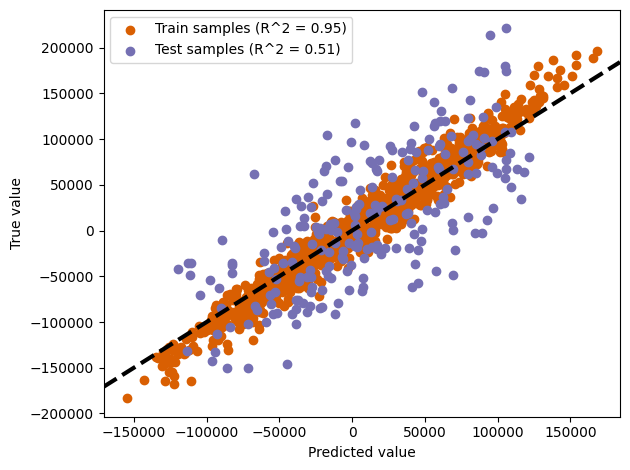

In [165]:
evaluate(
    model, 
    train_features.values, 
    test_features.values, 
    train_labels.values.ravel(), test_labels.values.ravel()
)

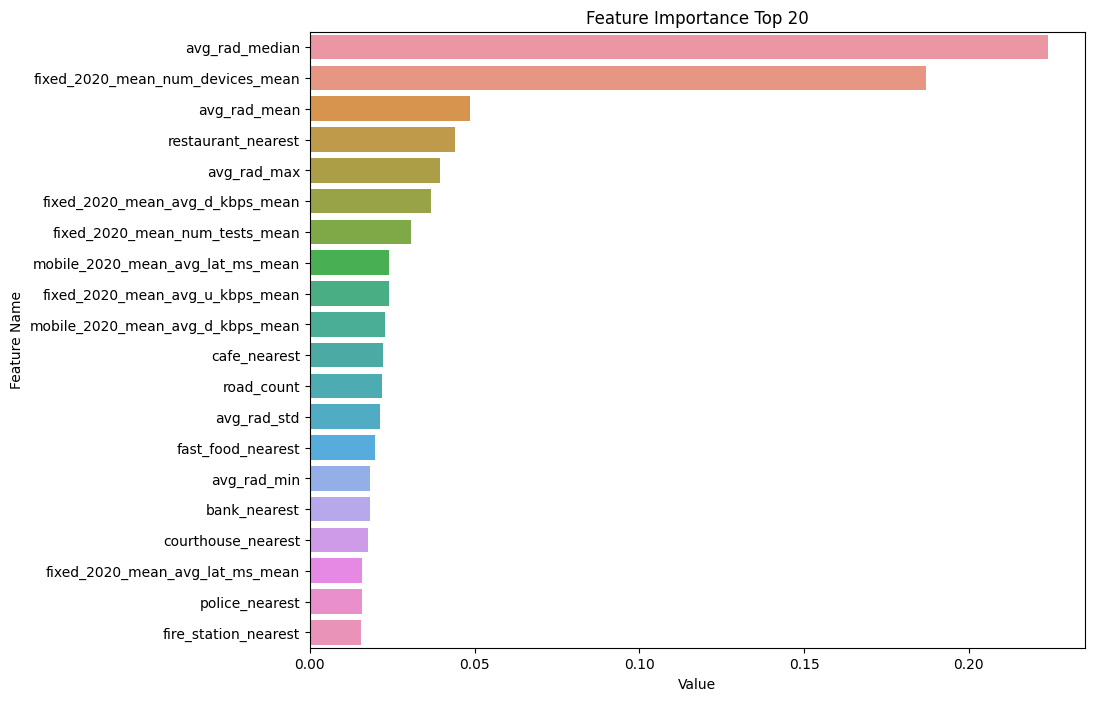

In [160]:
plot_feature_importance(model.feature_importances_, features.columns)